In [1]:
import mmcv
import cv2
import os
import glob
import sys
import numpy as np
import slidingwindow as sw
import pycocotools.mask as maskUtils
import matplotlib.pyplot as plt 

from mmdet.apis import init_detector, inference_detector
from skimage.measure import label, regionprops_table
from skimage.morphology import skeletonize

# import shm_tools here
sys.path.append('..')
from shm_tools.shm_utils import imread, imwrite, inference_detector_sliding_window, connect_cracks
from shm_tools.SlidingWindow import generateForNumberOfWindows

# Concrete crack connection algorithm 

### Algorithm overview 

1. Input crack masks obtained by a trained deep learning model 

2. Find starting and ending point of each crack along x axis

3. Measure distance between ending point of a crack (A) and starting point of another crack (B) 

4. Measure angle between 
    - vector A and vector B in the figure below (angle A)
    - vector B and vector C in the figure below (angle B)  
    
5. Repeat 3-4 through all the other cracks 

6. connect e2 and e1' if
    - their distance is the shortest and
    - their angle A and angle B are smaller than 45 degrees 
    
7. Repeat 3-6 for all the other cracks 

8. Repeat 3-7 for y axis 
    

In [6]:
# load checkpoint file and configuration 

config = '/home/uosshm/mmdetection/project_work_dirs/express_cor/configs/cascade_mask_rcnn_x101_64x4d_fpn_carafe_1x_road_crack_200318.py'
checkpoint = '/home/uosshm/mmdetection/project_work_dirs/express_cor/work_dirs/cascade_mask_rcnn_x101_64x4d_fpn_carafe_1x_road_crack_200318/epoch_30.pth'

device = 'cuda:0'
model = init_detector(config, checkpoint, device=device)


In [ ]:
img_path = '/home/uosshm/다운로드/intemediate_report_express_corp/P-004-E1-발안천교(서울)_s000002000.jpg'

# image = imread(img_path)
color_mask = np.array([255, 0, 0], dtype=np.uint8)

img_result, mask_output = inference_detector_sliding_window(model, img_path, color_mask, score_thr = 0.3, window_size = 1024, overlap_ratio = 0)


inference by sliding window on P-004-E1-발안천교(서울)_s000002000.jpg:  21%|##1       | 40/190 [00:40<02:45,  1.10s/it]

### Original image display

(-0.5, 18591.5, 9999.5, -0.5)

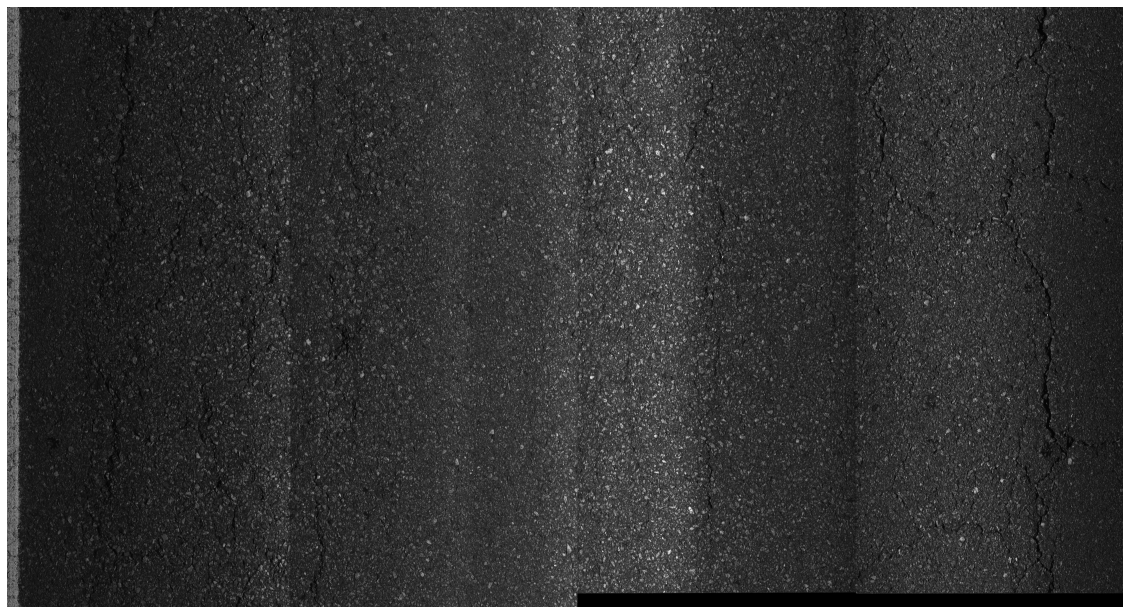

In [4]:
plt.figure(figsize =(20, 20))
plt.imshow(imread(img_path))
plt.axis('off')

### Crack detection result by a trained Cascade Mask R-CNN

(-0.5, 18591.5, 9999.5, -0.5)

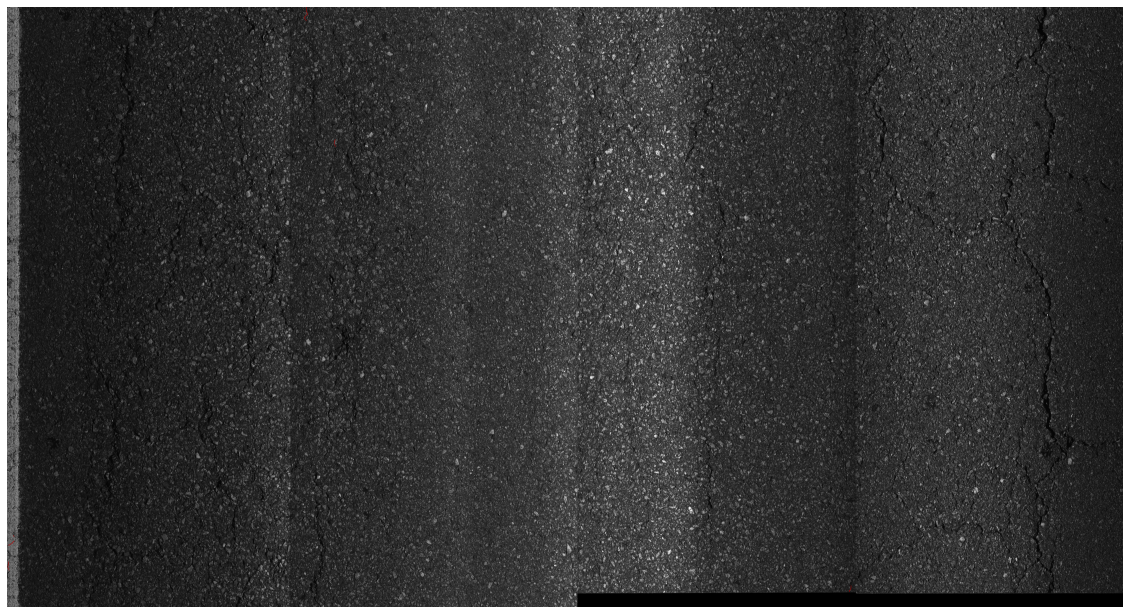

In [5]:
plt.figure(figsize =(20, 20))
plt.imshow(img_result)
plt.axis('off')

### Display only the masks of crack detection result 

(-0.5, 2447.5, 2447.5, -0.5)

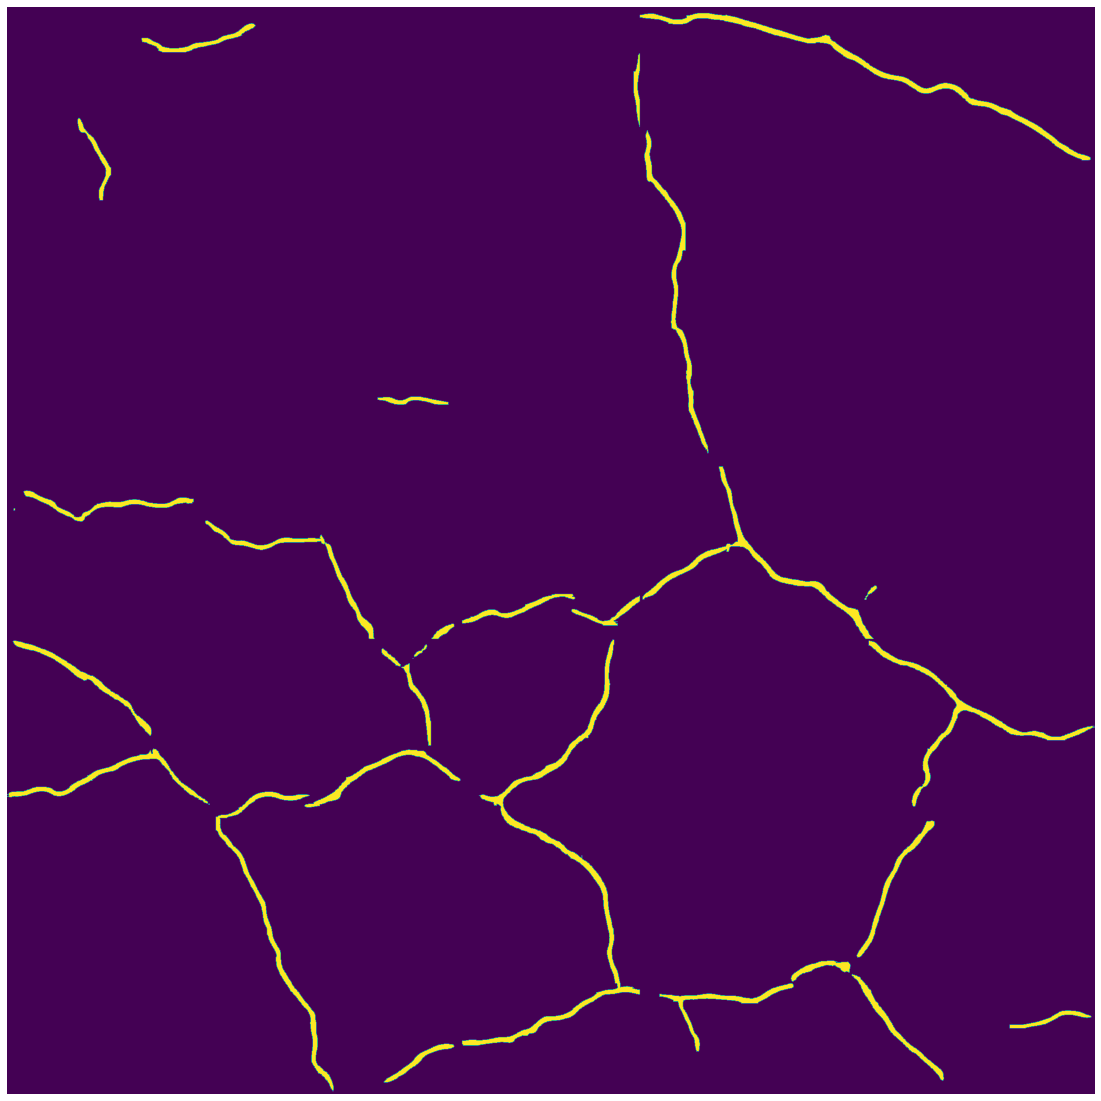

In [8]:
plt.figure(figsize =(20, 20))
plt.imshow(mask_output)
plt.axis('off')

In [9]:
kernel = np.ones((50, 50),np.uint8)

mask_output_dil = cv2.dilate(mask_output,kernel,iterations = 1)


(-0.5, 2447.5, 2447.5, -0.5)

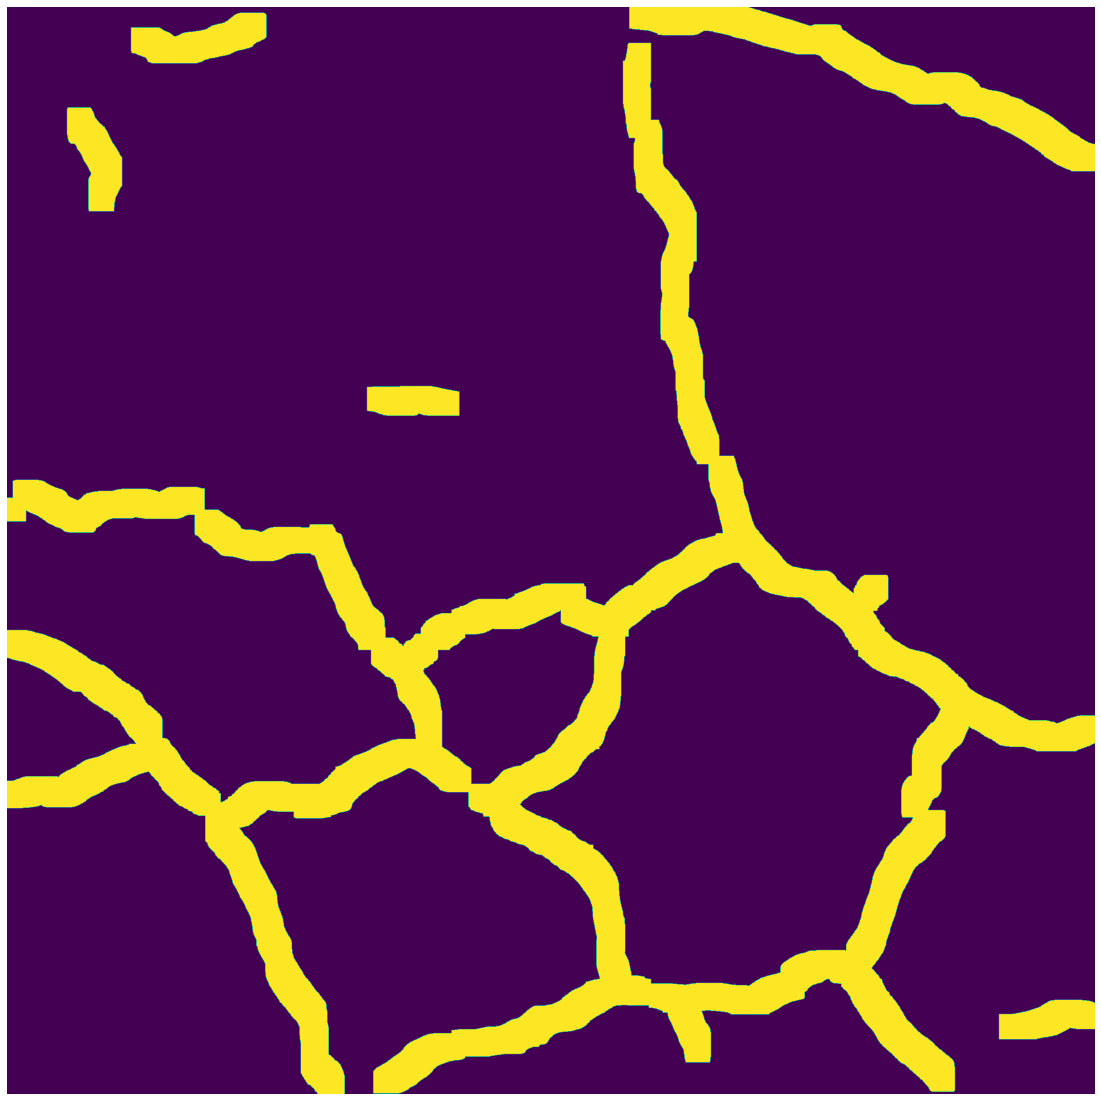

In [10]:
plt.figure(figsize =(20, 20))
plt.imshow(mask_output_dil)
plt.axis('off')

In [11]:
mask_label = label(1-mask_output_dil)

(-0.5, 2447.5, 2447.5, -0.5)

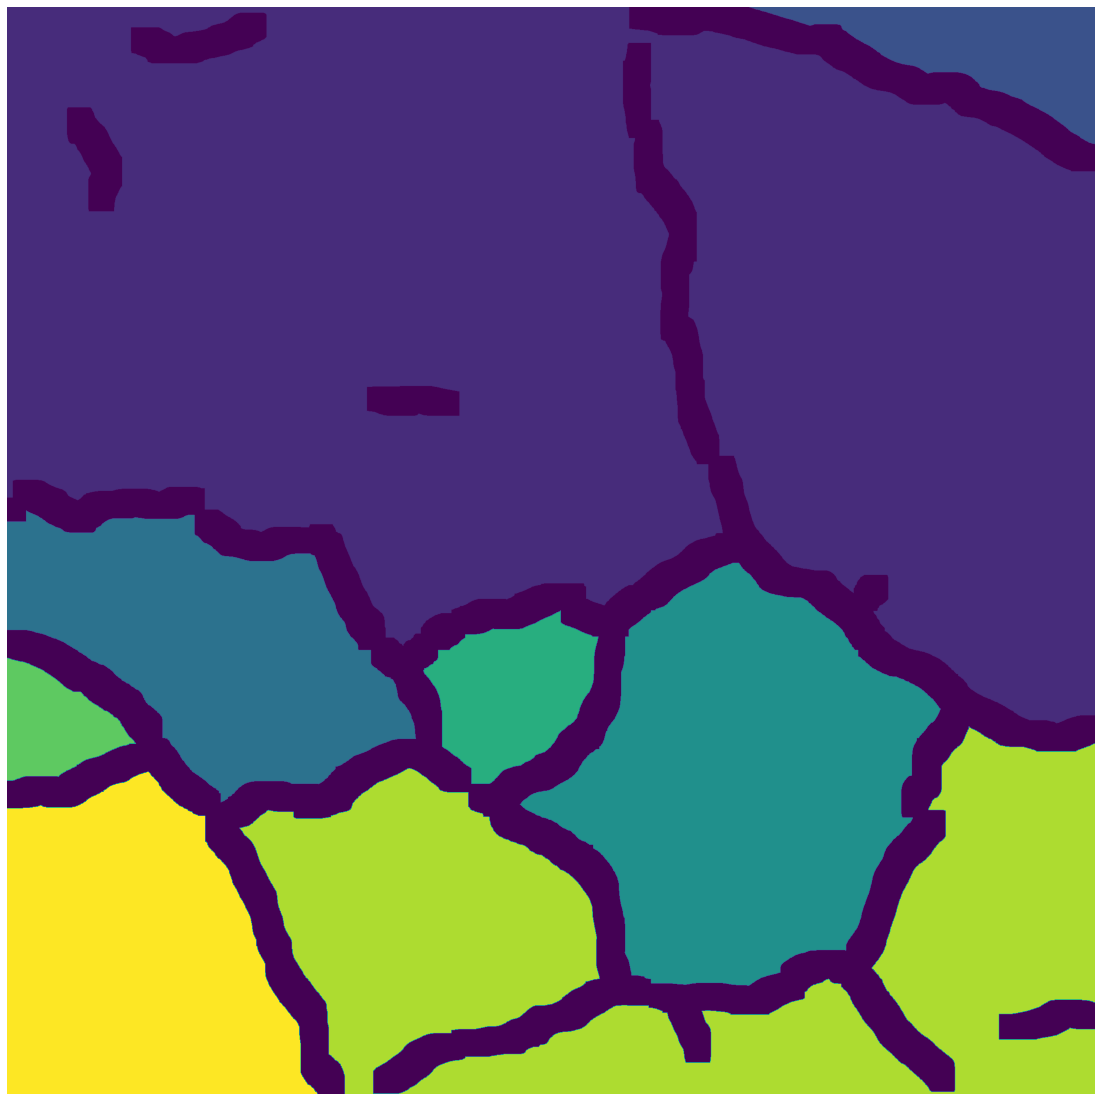

In [12]:
plt.figure(figsize =(20, 20))
plt.imshow(mask_label)
plt.axis('off')

In [13]:
if np.max(mask_label) > 8 :
    print('alligator crack')
else :
    print('normal crack')

normal crack


In [21]:
is_tunnel = False 
is_customize = True 
is_road = False

if is_tunnel : 
    window_size = 1000 
    # call sw by window size 
elif is_road : 
    windowCount = (3, 4)
    
elif is_customize : 
    windowCount = (1, 1)
    

    
img = imread(img_path)

windows = generateForNumberOfWindows(img, sw.DimOrder.HeightWidthChannel, windowCount, overlapPercent = 0, transforms=[])


In [46]:
for window in windows:
    img_subset = mask_output[window.indices()]
    labels, num = label(img_subset, connectivity=2, return_num=True)

In [43]:
mm_per_pixel = 0.3 
crack_skel = skeletonize(mask_output)
crack_length = np.sum(crack_skel)*mm_per_pixel
crack_area = crack_length*250/100
crack_area
window_area = (img_subset.shape[0]*mm_per_pixel)*(img_subset.shape[1]*mm_per_pixel)/100
window_area

5393.4336

In [47]:
crack_region_table = regionprops_table(labels, properties=('label', 'bbox', 'coords', 'orientation'))

In [55]:
if (np.std(crack_region_table['orientation']) > 45* 0.0174533) and crack_area > 0.5*window_area:
    print('alligator crack')

alligator crack
